# Baseline for ETH PSC Summer School Minileaves Hackathon
#### Authors : Sharada Mohanty, Gauransh Kumar

## Download Necessary Packages

In [ ]:
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install aicrowd-cli
%load_ext aicrowd.magic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 2.1 MB/s 
     |████████████████████████████████| 170 kB 9.4 MB/s 
     |████████████████████████████████| 54 kB 2.3 MB/s 
     |████████████████████████████████| 214 kB 43.7 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 1.1 MB 43.4 MB/s 
     |████████████████████████████████| 63 kB 1.1 MB/s 
     |████████████████████████████████| 51 kB 7.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requ

In [ ]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/SnnZYXpRRtgHer0udG64eCUvmSLURAz0nSKdt9yBRGw
API Key valid
Gitlab access token valid
Saved details successfully!


## Download data
The first step is to download our train and test datasets. We will be training a classifier on the training dataset and make predictions on test dataset.


In [ ]:
#Donwload the datasets
!rm -rf data
!mkdir data
%aicrowd ds dl -c eth-psc-summer-school-minileaves-hackathon -o data

ERROR:root:Error while reading the git config, 'NoneType' object has no attribute 'config_reader'


all_classes.txt:   0%|          | 0.00/887 [00:00<?, ?B/s]

sample_submission.csv:   0%|          | 0.00/29.7k [00:00<?, ?B/s]

test-images.npy:   0%|          | 0.00/33.3M [00:00<?, ?B/s]

train-images.npy:   0%|          | 0.00/134M [00:00<?, ?B/s]

train-labels.npy:   0%|          | 0.00/348k [00:00<?, ?B/s]


## Import packages

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
import matplotlib.pyplot as plt

## Load Data

In [ ]:
train_images_path = "data/train-images.npy" #path where data is stored
train_labels_path = "data/train-labels.npy"

train_images = np.load(train_images_path)
train_labels = np.load(train_labels_path)

# Load Class mapping
class_names = [x.strip() for x in open("data/all_classes.txt").readlines()]

## Visualize the data

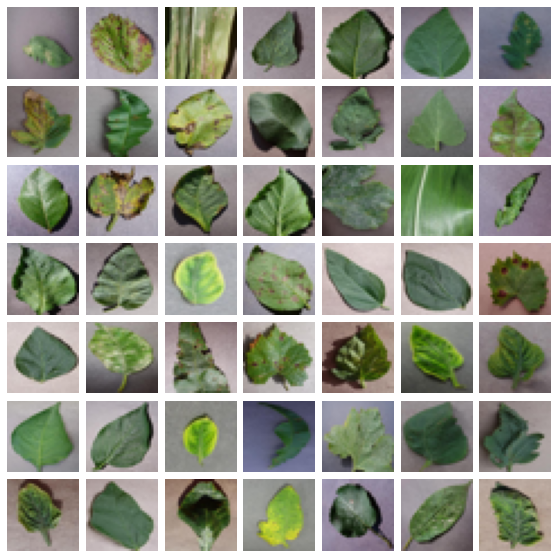

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

def random_data_sample():
    """
    Returns a random data sample from the training set
    """
    global class_name, train_images, train_labels
    random_index = np.random.randint(0, train_images.shape[0])
    # Render the image
    image_array = train_images[random_index]
    class_label = train_labels[random_index] # an integral number in [0-38)
    class_name = class_names[class_label] # a human readable class name
    return image_array, class_label, class_name

"""
Render a 7x7 grid of 49 randomly sampled images
from the training set
"""
grid_shape = (7, 7)
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=grid_shape,  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

data_samples = [random_data_sample() for _ in range(grid_shape[0] * grid_shape[1])]
for ax, data_sample in zip(grid, data_samples):
    image_array, class_label, class_name = data_sample
    ax.imshow(image_array)
    ax.axis('off')

plt.savefig("image-grid.png")

# Dataset Distribution

In [ ]:
from collections import Counter

data_counter = Counter(train_labels)
unique_class_indices = data_counter.keys()

for _class_index in unique_class_indices:
    print("Class Index : ", _class_index)
    print("Class Name : ", class_names[_class_index])
    print("Number of images in the dataset : ", data_counter[_class_index])
    print("="*100)
# TODO : Add a bar plot of the distribution of the classes here

Class Index :  7
Class Name :  corn-maize-cercospora-leaf-spot-gray-leaf-spot
Number of images in the dataset :  410
Class Index :  4
Class Name :  blueberry-healthy
Number of images in the dataset :  1205
Class Index :  9
Class Name :  corn-maize-healthy
Number of images in the dataset :  925
Class Index :  29
Class Name :  tomato-early-blight
Number of images in the dataset :  806
Class Index :  20
Class Name :  potato-early-blight
Number of images in the dataset :  808
Class Index :  15
Class Name :  orange-haunglongbing-citrus-greening
Number of images in the dataset :  4422
Class Index :  37
Class Name :  tomato-tomato-yellow-leaf-curl-virus
Number of images in the dataset :  4238
Class Index :  5
Class Name :  cherry-including-sour-healthy
Number of images in the dataset :  666
Class Index :  28
Class Name :  tomato-bacterial-spot
Number of images in the dataset :  1738
Class Index :  16
Class Name :  peach-bacterial-spot
Number of images in the dataset :  1864
Class Index :  14


## Split Data into Train and Validation
Now we eventually want to see how well our classifier is performing, but we dont have the test data labels with us to check.
What do we do ? We split our dataset into a training set and a validation set. The idea is that we test our classifier on validation set in order to get an idea of how well our classifier works. This way we can also ensure that we dont [overfit](https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/) on the training dataset. 

In [ ]:
X_train, X_val= train_test_split(train_images, test_size=0.2, random_state=42)
y_train, y_val= train_test_split(train_labels, test_size=0.2, random_state=42) 
## Note : Given that we use the same random state in both the splits, 
## and both `train_images` and `train_labels` have the same number of (aligned) elements, 
## the overall alignment between X_train and the corresponding Y_train will be retained. 

Here we have selected the size of the testing data to be 20% of the total data. You can change it and see what effect it has on the accuracies. To learn more about the train_test_split function [click here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

## Define the Classifier
Now we come to the juicy part. We have fixed our data and now we train a classifier. The classifier will learn the function by looking at the inputs and corresponding outputs. There are a ton of classifiers to choose from some being [Logistic Regression](https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc), [SVM](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47), [Random Forests](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47), [Decision Trees](https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052), etc.   
Tip: A good model doesnt depend solely on the classifier but on the features(columns) you choose. So make sure to play with your data and keep only whats important. 

In [22]:
classifier = MLPClassifier(hidden_layer_sizes=(20, 20), max_iter=30)

#from sklearn.linear_model import LogisticRegression
# classifier = LogisticRegression()

## NOTE : This is definitely not the most optimal approach for this problem. 
## This code is provided to help you get started quickly, and should be treated
## as suck

We have used a very simple [Multi Layer Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) as a classifier here and set few of the parameteres. But one can set more parameters and increase the performance. To see the list of parameters visit [here](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).

We can also use other classifiers. To read more about sklean classifiers visit [here](https://scikit-learn.org/stable/supervised_learning.html). Try and use other classifiers to see how the performance of your model changes. Try using [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) or [MLP](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) and compare how the performance changes.

# Define data pre-processors

In [ ]:
"""
Some of the models have different requirements in terms of what form of the data they can consume.

In this example, we will use 
a very simple Multi Layer Perceptron (explained further in the notebook), 
which expects a single dimensional representation for every data point. 

Hence, we will define some pre-processors which can help flatten the data,
and also normalize the data as necessary.
"""

def preprocess_X(X_array):
    assert X_array.shape[1:] == (32, 32, 3) # as the images are of the dimension 32x32x3
    
    # We normalize the whole array to a [0-1] range. As the pixel RGB values are uint8 values in the range[0, 256], 
    # we will normalize simply by dividing the whole array by 255
    X_array = X_array.astype(np.float32) / 255.0
    
    # Now, we will reshape the ndarray of shape (N, 32, 32, 3) to (N, 32*32*3), where N is the number of samples
    # present in the dataset
    X_array = X_array.reshape(X_array.shape[0], 32*32*3)
    return X_array

X_train = preprocess_X(X_train)
X_val = preprocess_X(X_val)

## Train the classifier

In [24]:
classifier.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(hidden_layer_sizes=(20, 20), max_iter=30)

## Predict on Validation
Now we predict our trained classifier on the validation set and evaluate our model

In [ ]:
y_pred = classifier.predict(X_val)

## Evaluate the Performance
We use the same metrics as that will be used for the test set.  
[F1 score](https://en.wikipedia.org/wiki/F1_score) and [Log Loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) are the metrics for this challenge

In [ ]:
precision = precision_score(y_val,y_pred,average='micro')
recall = recall_score(y_val,y_pred,average='micro')
accuracy = accuracy_score(y_val,y_pred)
f1 = f1_score(y_val,y_pred,average='macro')

In [ ]:
print("Accuracy of the model is :" ,accuracy)
print("Recall of the model is :" ,recall)
print("Precision of the model is :" ,precision)
print("F1 score of the model is :" ,f1)

Accuracy of the model is : 0.39832068092937656
Recall of the model is : 0.39832068092937656
Precision of the model is : 0.39832068092937656
F1 score of the model is : 0.18309288085008343


# Prediction on Evaluation Set

## Load Test Set

In [ ]:
test_file_path = "data/test-images.npy"
test_images = np.load(test_file_path)

## Predict Test Set
The moment of truth! Predict on test set and then we can make the submission.

In [ ]:
# We first pre-process the test images, the same way we pre-process the train images
test_images = preprocess_X(test_images)

submission = classifier.predict(test_images)

## Save the prediction to csv

In [ ]:
#change the header according to the submission guidelines

In [ ]:
import pandas as pd
# Saving the pandas dataframe
!rm -rf assets
!mkdir assets
submission = pd.DataFrame(submission)
submission.to_csv('assets/submission.csv',header=['class_index'],index=False)

Note: Do take a look at the submission format.The submission file should contain a header.

## Make a submission using the aicrowd-cli

In [ ]:
!!aicrowd submission create -c eth-psc-summer-school-minileaves-hackathon -f assets/submission.csv

['\x1b[?25l\x1bsubmission.csv\x1b \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0%\x1b • \x1b0.0/31.4 KB\x1b • \x1b?\x1b • \x1b-:--:--\x1b',
 '\x1b[2K\x1bsubmission.csv\x1b \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0%\x1b • \x1b0.0/31.4 KB\x1b • \x1b?\x1b • \x1b-:--:--\x1b',
 '\x1b[2K\x1bsubmission.csv\x1b \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0%\x1b • \x1b0.0/31.4 KB\x1b • \x1b?\x1b • \x1b-:--:--\x1b',
 '\x1b[2K\x1bsubmission.csv\x1b \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0%\x1b • \x1b0.0/31.4 KB\x1b • \x1b?\x1b • \x1b-:--:--\x1b',
 '\x1b[2K\x1bsubmission.csv\x1b \x1b━━━━━━━━\x1b\x1b╺\x1b\x1b━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b26.1%\x1b • \x1b8.2/31.4 KB\x1b • \x1b?\x1b • \x1b-:--:--\x1b',
 '\x1b[2K\x1bsubmission.csv\x1b \x1b━━━━━━━━━━━━\x1b\x1b╺\x1b\x1b━━━━━━━━━━\x1b \x1b52.3%\x1b • \x1b16.4/31.4 KB\x1b • \x1b2.5 MB/s\x1b • \x1b0:00:01\x1b',
 '\x1b[2K\x1bsubmission.csv\x1b \x1b━━━━━━━━━━━━━━━━━━\x1b\x1b╺\x1b\x1b━━━━\x1b \x1b78.4%\x1b • \x1b24.6/31.4 KB\x1b • \x1b2.7